In [1]:
!pip install -q datasets pingouin umap-learn

import datasets
from datasets import load_dataset

from transformers import AutoTokenizer, AutoModelForSequenceClassification

import numpy as np
import pandas as pd

from sklearn.svm import OneClassSVM
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from umap.umap_ import UMAP

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from pingouin import multivariate_normality

import torch
from torch import nn
from torch.utils.data import DataLoader

from tqdm.auto import tqdm

from matplotlib import pyplot as plt
import seaborn as sns

from copy import deepcopy
from sys import getsizeof

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 24.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.4/204.4 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 14.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

### Датасет

В качестве датасета был выбран датасет SST-2 с отзывами к фильмам

In [3]:
dataset_path = 'SetFit/sst2'

Функция для скачивания датасета

In [4]:
def get_dataset(path, split=None, streaming=False, columns=[]):
    return load_dataset(path, split=split, streaming=streaming).remove_columns(columns)

#### Различные параметры скачивания

Скачаем все части датасета - тренировочную, валидационную и тестовую

In [5]:
all_datasets = get_dataset(dataset_path)
all_datasets

README.md:   0%|          | 0.00/378 [00:00<?, ?B/s]

Repo card metadata block was not found. Setting CardData to empty.


train.jsonl:   0%|          | 0.00/1.07M [00:00<?, ?B/s]

dev.jsonl:   0%|          | 0.00/136k [00:00<?, ?B/s]

test.jsonl:   0%|          | 0.00/281k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/6920 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/872 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1821 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'label_text'],
        num_rows: 6920
    })
    validation: Dataset({
        features: ['text', 'label', 'label_text'],
        num_rows: 872
    })
    test: Dataset({
        features: ['text', 'label', 'label_text'],
        num_rows: 1821
    })
})

 Теперь только тренировочную

In [6]:
train_part = get_dataset(dataset_path, split='train')
train_part

Repo card metadata block was not found. Setting CardData to empty.


Dataset({
    features: ['text', 'label', 'label_text'],
    num_rows: 6920
})

Возьмём строки с 1000 по 6000 от тренирочной части

In [7]:
train_part_numbers = get_dataset(dataset_path, split='train[1000:6000]')
train_part_numbers

Repo card metadata block was not found. Setting CardData to empty.


Dataset({
    features: ['text', 'label', 'label_text'],
    num_rows: 5000
})

Возьмём строки с 25 по 75 процентили

In [8]:
train_part_percents = get_dataset(dataset_path, split='train[25%:75%]')
train_part_percents

Repo card metadata block was not found. Setting CardData to empty.


Dataset({
    features: ['text', 'label', 'label_text'],
    num_rows: 3460
})

Теперь опробуем параметр streaming на тренировочной выборке - он позволяет не скачивать все данные сразу, а подгружать по мере надобности



Следует отметить, что возвращаться будет на Dataset, а IterableDataset, представляющий собой как бы итератор над датасетом

In [9]:
train_part_streaming = get_dataset(dataset_path, split='train', streaming=True)
train_part_streaming

Repo card metadata block was not found. Setting CardData to empty.


IterableDataset({
    features: ['text', 'label', 'label_text'],
    num_shards: 1
})

Так как у нас датасет не большой, то можно его загрузить сразу целиком

#### Статистика

In [10]:
all_datasets

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'label_text'],
        num_rows: 6920
    })
    validation: Dataset({
        features: ['text', 'label', 'label_text'],
        num_rows: 872
    })
    test: Dataset({
        features: ['text', 'label', 'label_text'],
        num_rows: 1821
    })
})

Итак, есть сразу 3 датасета:
- Тренировочный - 6920 записей
- Валидационный - 872 записи
- Тестовый - 1821 запись

В каждом есть 1 признак - текст, а также целевая переменная - метка класа, дублирующаяся названием метки

Выведем примеры записей

In [11]:
all_datasets['train'][:5]

{'text': ['a stirring , funny and finally transporting re-imagining of beauty and the beast and 1930s horror films',
  'apparently reassembled from the cutting-room floor of any given daytime soap .',
  "they presume their audience wo n't sit still for a sociology lesson , however entertainingly presented , so they trot out the conventional science-fiction elements of bug-eyed monsters and futuristic women in skimpy clothes .",
  'this is a visually stunning rumination on love , memory , history and the war between art and commerce .',
  "jonathan parker 's bartleby should have been the be-all-end-all of the modern-office anomie films ."],
 'label': [1, 0, 0, 1, 1],
 'label_text': ['positive', 'negative', 'negative', 'positive', 'positive']}

Узнаем, сколько заимет каждая запись датасета в байтах

In [12]:
for key in 'train', 'validation', 'test':
    print(getsizeof(all_datasets[key][0]))

232
232
232


Напишем функцию для отрисовки гистограммы распределения объектов по классам для всех 3 датасетов

In [13]:
def countplot(key, ax, datasets=all_datasets, palette=['#432371',"#FAAE7B"], x='label_text'):
    sns.countplot(datasets[key][:], x=x, hue=x, ax=ax, palette=palette, legend=False)
    for container in ax.containers:
        ax.bar_label(container)
    ax.set_title(key)

И визуализируем гистограммы

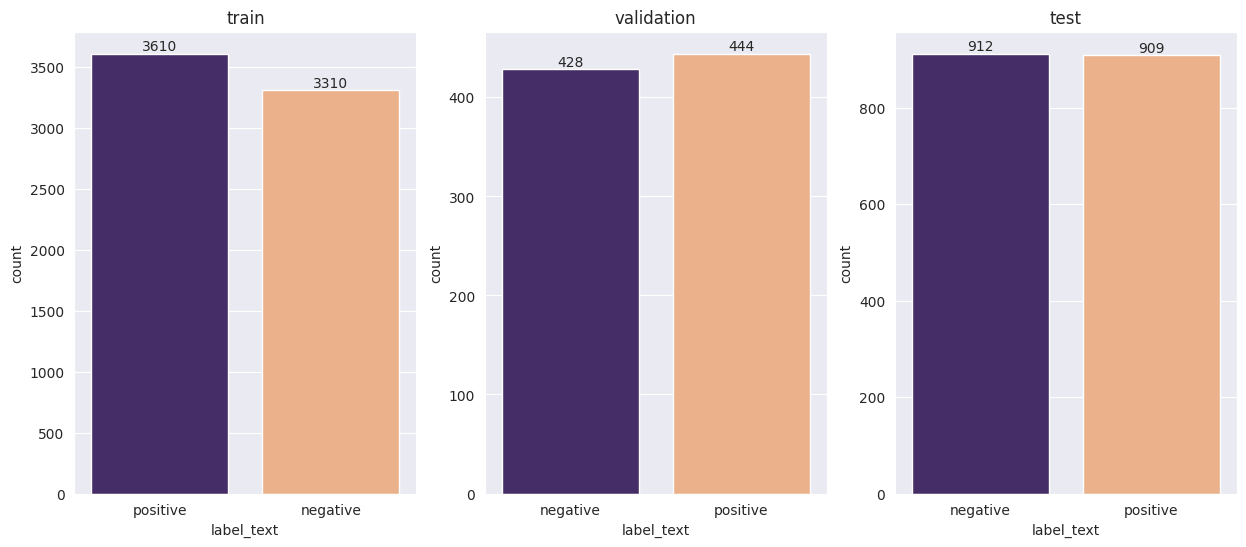

In [14]:
sns.set_style('darkgrid')
_, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 6))
for ax, key in zip(axes, ['train', 'validation', 'test']):
    countplot(key, ax)
plt.show()

Видим, что явного дизбаланса классов ни в одном из датасетов нет, поэтому если бы потребовалось обучать модель на этих данных, то средства борьбы с переобучением применять скорее всего не пришлось бы

### Задача и модель

Этот датасет использовался для задачи бинарной классификации отзывов на позитивные и негативные



На платформе hugging face также оказалась уже предобученная модель на данной задаче

In [15]:
model_path = 'distilbert/distilbert-base-uncased-finetuned-sst-2-english'
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path).to(device)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Нужно дообучить нашу модель, так как веса в полновязном классификаторе инициализируютя случайным образом

Напишем функцию для токенизации датасетов

In [16]:
def preprocess(
    examples, text_column='text', tokenizer=tokenizer, max_length=256,
    return_token_type_ids=False, return_attention_mask=False

):
    return tokenizer(
        examples[text_column], truncation=True, max_length=max_length,
        return_attention_mask=return_attention_mask,
        return_token_type_ids=return_token_type_ids
    )

In [17]:
def tokenize(dataset, remove_columns):
    return dataset.map(preprocess, batched=True).remove_columns(remove_columns)

In [18]:
all_datasets_tokenized = tokenize(all_datasets, remove_columns=['text', 'label_text'])
all_datasets_tokenized

Map:   0%|          | 0/6920 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/1821 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['label', 'input_ids'],
        num_rows: 6920
    })
    validation: Dataset({
        features: ['label', 'input_ids'],
        num_rows: 872
    })
    test: Dataset({
        features: ['label', 'input_ids'],
        num_rows: 1821
    })
})

Напишем collate-функцию для обёртки протокенизированных датасетов в даталодеры

In [19]:
def collate_fn(batch, padding_index=tokenizer.pad_token_id):
    lengths = [len(obj['input_ids']) for obj in batch]
    max_length = max(lengths)
    input_ids = torch.LongTensor([obj['input_ids'] + [padding_index] * (max_length - len(obj['input_ids'])) for obj in batch]).to(device)
    attention_mask = torch.LongTensor([[1] * len(obj['input_ids']) + [0] * (max_length - len(obj['input_ids'])) for obj in batch]).to(device)
    labels = torch.LongTensor([obj['label'] for obj in batch]).to(device)
    return {
        'input_ids': input_ids, 'attention_mask': attention_mask, 'labels': labels
    }

Теперь создадим даталодеры для тренировочного, валидационного и тестового датасетов

In [20]:
batch_size = 16
train_dataloader = DataLoader(all_datasets_tokenized['train'], batch_size=batch_size, collate_fn=collate_fn)
valid_dataloader = DataLoader(all_datasets_tokenized['validation'], batch_size=batch_size, collate_fn=collate_fn)
test_dataloader = DataLoader(all_datasets_tokenized['test'], batch_size=batch_size, collate_fn=collate_fn)

Напишем функцию для получения предсказаний и классов объектов

In [21]:
def get_preds_and_labels(model, dataloader):
    total_preds, total_labels = [np.array([]) for _ in range(2)]
    model.eval()
    with torch.no_grad():
        for batch in tqdm(dataloader):
            labels = batch['labels']
            del batch['labels']
            output = model(**batch).logits
            total_preds = np.concatenate((total_preds, torch.argmax(output, dim=1).cpu().numpy()))
            total_labels = np.concatenate((total_labels, labels.cpu().numpy()))

    return total_preds, total_labels

Далее для каждого из даталодеров посчитаем значения следующих метрик:

- accuracy

- precision

- recall

- f1



Потом сохраним эти результаты в один pd.DataFrame

In [22]:
zipped_metrics = zip([accuracy_score, precision_score, recall_score, f1_score], ['accuracy', 'precision', 'recall', 'f1'])
zipped_dataloaders = zip([train_dataloader, valid_dataloader, test_dataloader], ['train', 'valid', 'test'])

In [23]:
def get_score(model, zipped_dataloaders, zipped_metrics=zipped_metrics):
    result = pd.DataFrame()
    for dataloader, title in zipped_dataloaders:
        preds, labels = get_preds_and_labels(model, dataloader)
        current = pd.DataFrame({
            name: [score(labels, preds)] for score, name in deepcopy(zipped_metrics)
        }, index=[title])
        result = pd.concat((result, current))
    return result

In [24]:
scores = get_score(model, zipped_dataloaders)
scores

  0%|          | 0/433 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/114 [00:00<?, ?it/s]

,accuracy,precision,recall,f1
train,0.991618,0.993882,0.990028,0.991951
valid,0.909404,0.897603,0.927928,0.912514
test,0.922570,0.905920,0.942794,0.923989


### Поиск выбросов

Задача модели BERT - выучить эмбеддинговые представления для отдельных текстовых записей в датасете (в нашем случае для каждого отзыва бдет своё эмбеддинговое представление)

Получим их, используя эмбеддинг первого токена (это служебный токен CLS) для тренировочного даталодера

In [25]:
def get_embeddings(model, dataloader, size):
    embeddings = torch.empty([0, size], dtype=torch.float, device=device)
    model.eval()
    with torch.no_grad():
        for batch in tqdm(dataloader):
            del batch['labels']
            local_embeddings = model(**batch).last_hidden_state[:, 0, :]
            embeddings = torch.vstack((embeddings, local_embeddings))

    embeddings = embeddings.cpu().numpy()
    return embeddings

In [26]:
embeddings = get_embeddings(model.distilbert, train_dataloader, 768)

  0%|          | 0/433 [00:00<?, ?it/s]

Итак, мы получили эмбеддинговое представление для каждого предложения в тренировочном датасете

Теперь опробуем на получившейся матрице некоторые алгоритмы для поиска выбросов

Для начала напишем функцию, которая по алгоритму и датасету вернёт предсказания для объектов, являются они выбросами или нет

In [27]:
def predict_outliers(algorithm, X=embeddings):
    return algorithm().fit_predict(X)

В качестве алгоритмов используем одноклассовый SVM, изолированный лес и локальный уровень выброса

In [28]:
%%time
one_class_svm_preds = predict_outliers(OneClassSVM)
isolation_forest_preds = predict_outliers(IsolationForest)
local_outlier_factor_preds = predict_outliers(LocalOutlierFactor)

CPU times: user 31.9 s, sys: 316 ms, total: 32.2 s
Wall time: 32.4 s


Такой алгоритм как эллиптический конверт очень хорошо выявляет аномалии, если данные распределены нормально

Проведём статистический тест на нормальность Хенце-Цирклера для многомерных данных

In [29]:
multivariate_normality(embeddings)

HZResults(hz=27680, pval=0.0, normal=False)

На уровне значимости 0.05 отвергаем нулевую гипотезу о нормальном распределении данных

Можно всё равно попробовать применить алгоритм, но хороших результатов в таком случае ждать не стоит, так как p-value околонулевой

In [30]:
%%time
elliptic_envelope_preds = predict_outliers(EllipticEnvelope)

/usr/local/lib/python3.10/dist-packages/sklearn/covariance/_robust_covariance.py:185: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-21180.072135267302656 > -21198.285722272485145). You may want to try with a higher value of support_fraction (current value: 0.557).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/covariance/_robust_covariance.py:185: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-21236.825992172907718 > -21241.756092258474382). You may want to try with a higher value of support_fraction (current value: 0.557).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/covariance/_robust_covariance.py:185: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-21222.587765339420002 > -21232.027806815007352). You may want to try with a higher value of support_fraction (current value: 0.557).
  warnings.warn

CPU times: user 11min 53s, sys: 2min 30s, total: 14min 23s
Wall time: 8min 45s


### Методы понижения размерности

Понизим размерность наших данных с 768 до 2, а потом визуализиуем полученные точки, заодно пометив выбросы и по графику определив, какие алгоритмы отработали лучше других

Напишем функцию, которая по алгоритму и датсету возвращает новый датасет, который после применения алгоритма имеет меньшую размерноть

In [31]:
def reduce_dimension(algorithm, X=embeddings, n_components=2):
    return algorithm(n_components=n_components).fit_transform(X)

Опробуем такие алгоритмы, как PCA, TSNE и UMAP

In [32]:
%%time
embeddings_PCA = reduce_dimension(PCA)
embeddings_TSNE = reduce_dimension(TSNE)
embeddings_UMAP = reduce_dimension(UMAP)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


CPU times: user 1min 52s, sys: 823 ms, total: 1min 53s
Wall time: 1min 47s


### Визуализация

Пришло время визуализироать полученные "сжатые" данные

Происходить это будет следующим образом - для каждого алгоритма уменьшения размерности будут по очереди перебираться и визуализироваться "отклассифицированные" по выбросам данные

Определим фунцию для визуализации точек

In [69]:
sns.set(style='ticks')

In [53]:
def visualize(preds, reduced, title, figsize=(15, 6)):
    plt.subplots(figsize=figsize)
    points, outliers = np.where(preds == 1)[0], np.where(preds == -1)[0]
    plt.scatter(reduced[points][:, 0], reduced[points][:, 1], color='blue', label='Points')
    plt.scatter(reduced[outliers][:, 0], reduced[outliers][:, 1], color='red', label='Outliers')
    plt.grid()
    plt.legend()
    plt.title(title)
    plt.show()

#### PCA

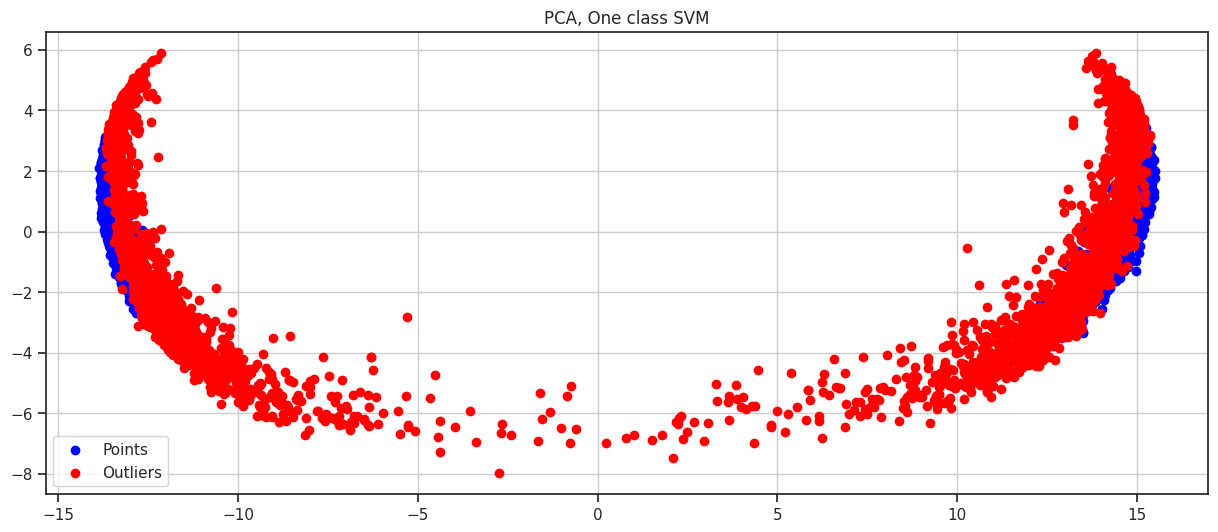

In [70]:
visualize(one_class_svm_preds, embeddings_PCA, 'PCA, One class SVM')

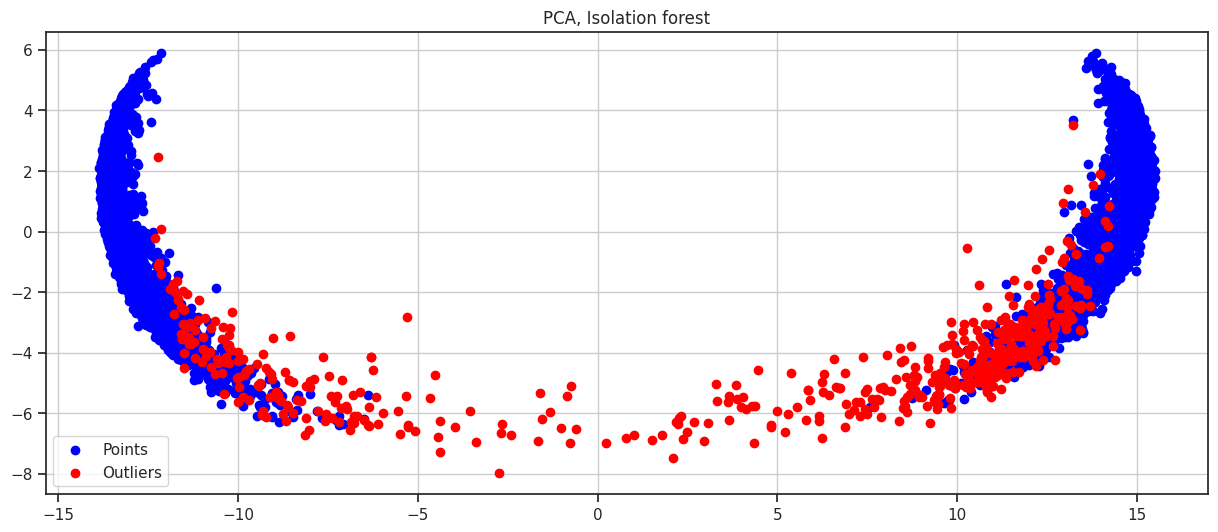

In [56]:
visualize(isolation_forest_preds, embeddings_PCA, 'PCA, Isolation forest')

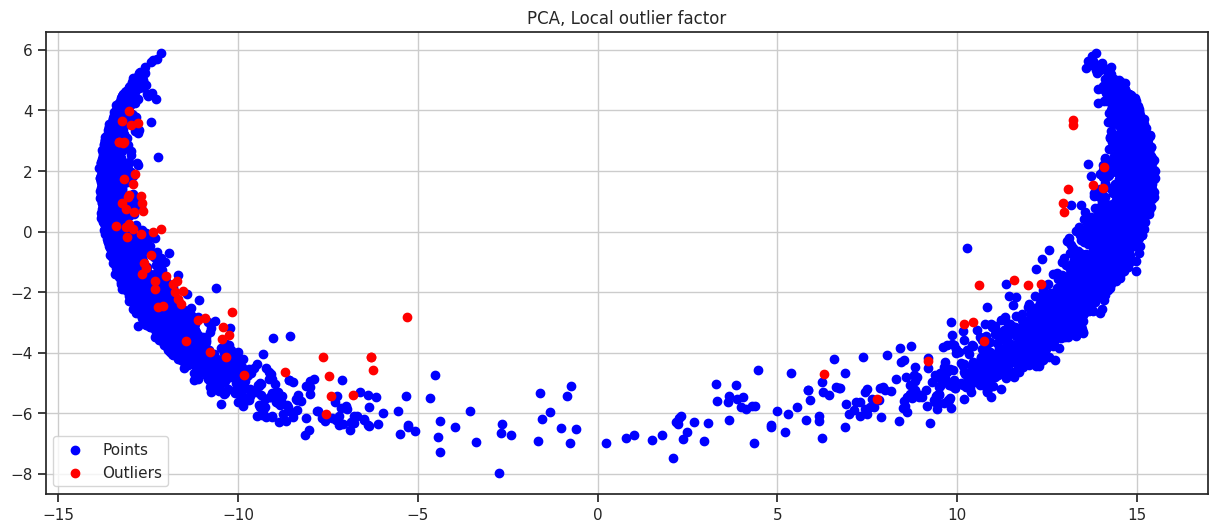

In [57]:
visualize(local_outlier_factor_preds, embeddings_PCA, 'PCA, Local outlier factor')

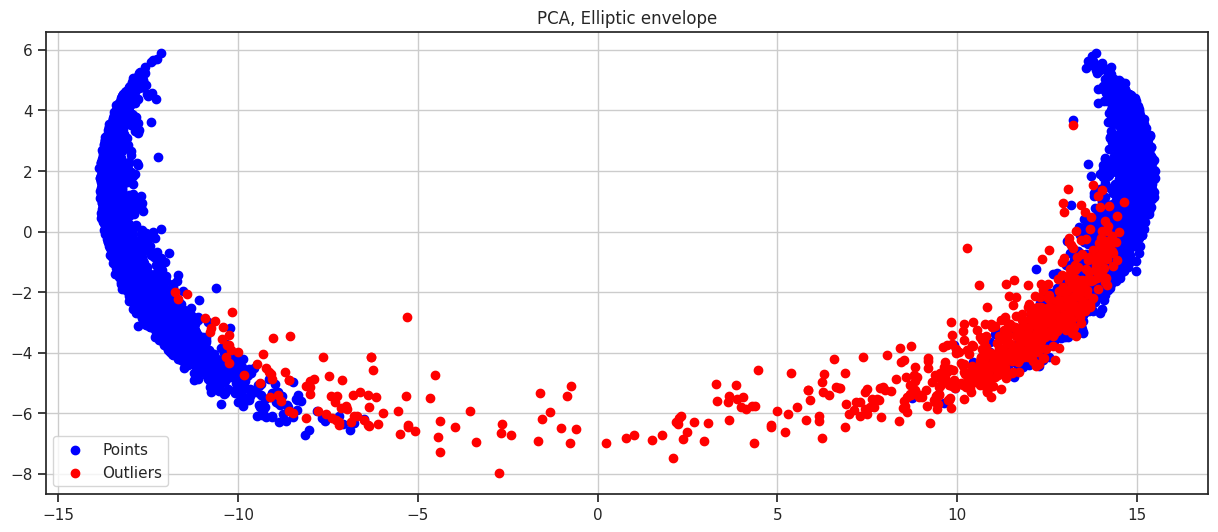

In [58]:
visualize(elliptic_envelope_preds, embeddings_PCA, 'PCA, Elliptic envelope')

PCA сжал данные так, что получалась своебразная арка с ярковыделенными боковыми частями и довольно разреженной нижней частью
- Однокласовый SVM половину объектов записал в выбросы, как будто просто разделил данные на 2 класса
- Изоляционный лес отнёс к выбросам куда меньшее число записей, при этом вся нижняя часть арки причисляется к ним, а также некоторые центральные или внешние точки в боковых частях
- Локальный уровень выброса нашёл ещё меньшее количество выбросов, уменьшив их количество в боковых частях и вернув нижнюю часть арки обычным точкам (не выбросам)
- Эллиптический конверт во многом похож на изоляционный лес за исключение того, что выбросы меньше сконцентрированы в левой части арки, а больше - в правой

#### TSNE

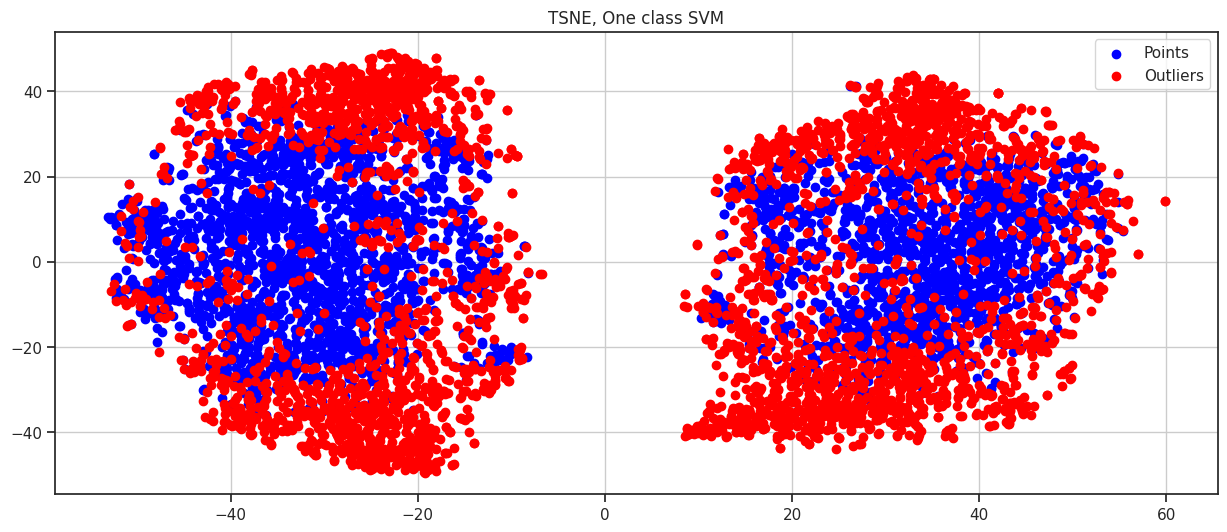

In [59]:
visualize(one_class_svm_preds, embeddings_TSNE, 'TSNE, One class SVM')

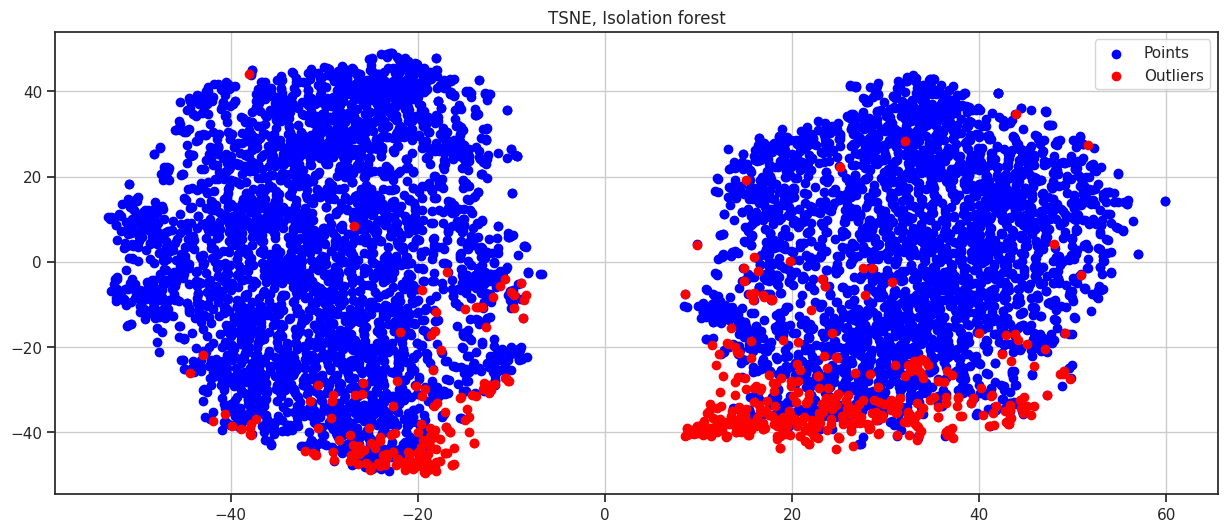

In [60]:
visualize(isolation_forest_preds, embeddings_TSNE, 'TSNE, Isolation forest')

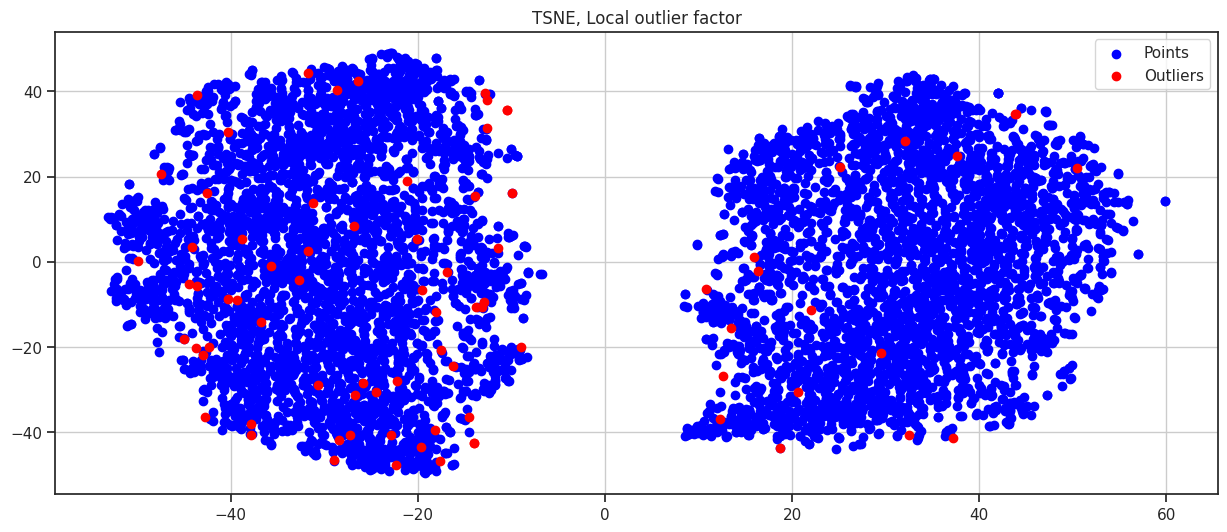

In [61]:
visualize(local_outlier_factor_preds, embeddings_TSNE, 'TSNE, Local outlier factor')

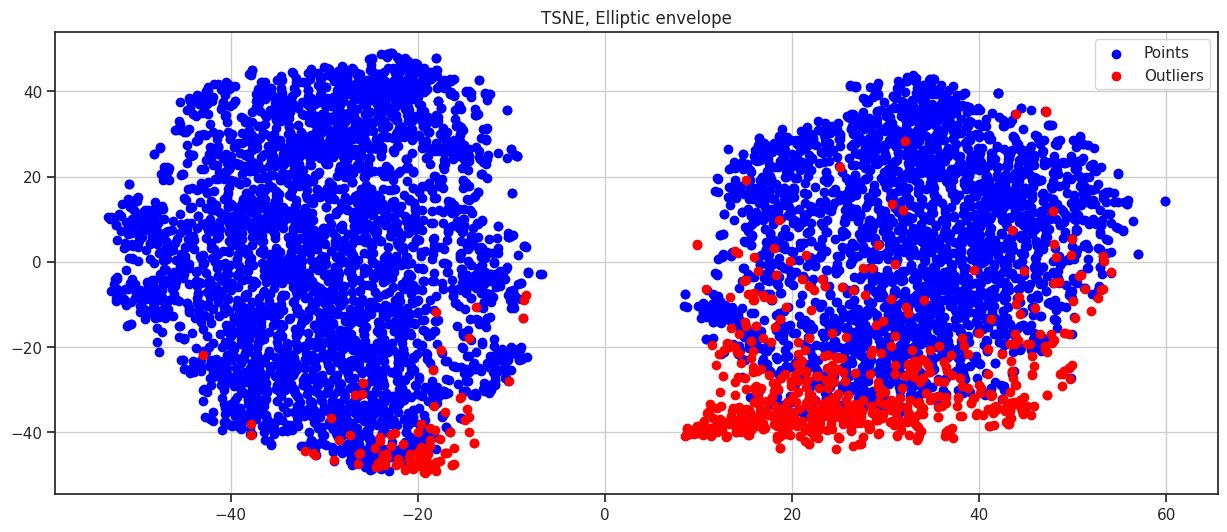

In [62]:
visualize(elliptic_envelope_preds, embeddings_TSNE, 'TSNE, Elliptic envelope')

Результатом работы TSNE являются 2 локальных кластера
- Однокласовый SVM отнёс верхние, нижние части кластеров и часть их граничных точек к выбросам
- Изоляционный лес оставил верха кластеров в покое, а их низы и малую часть центральных точек оставил за выбросами
- Локальный уровень выброса как будто отнёс к выбросам очень малое количество случайных точек в каждом кластере
- Эллиптический конверт по-прежнему очень сильно напоминает изоляционный лес, но часть выбросов в левом кластере исчезла, а в правом - прибавилась

#### UMAP

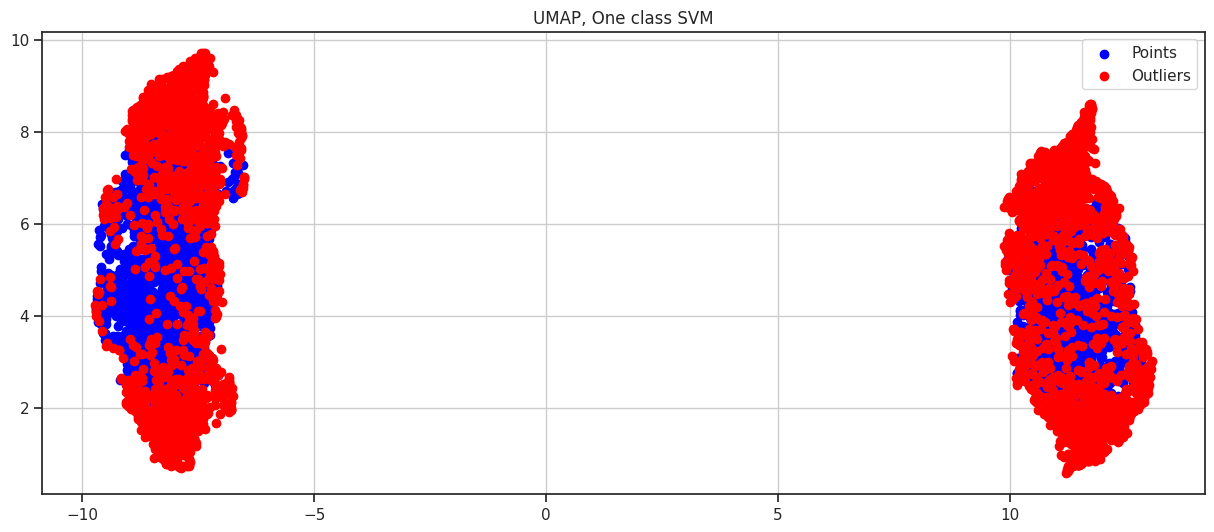

In [63]:
visualize(one_class_svm_preds, embeddings_UMAP, 'UMAP, One class SVM')

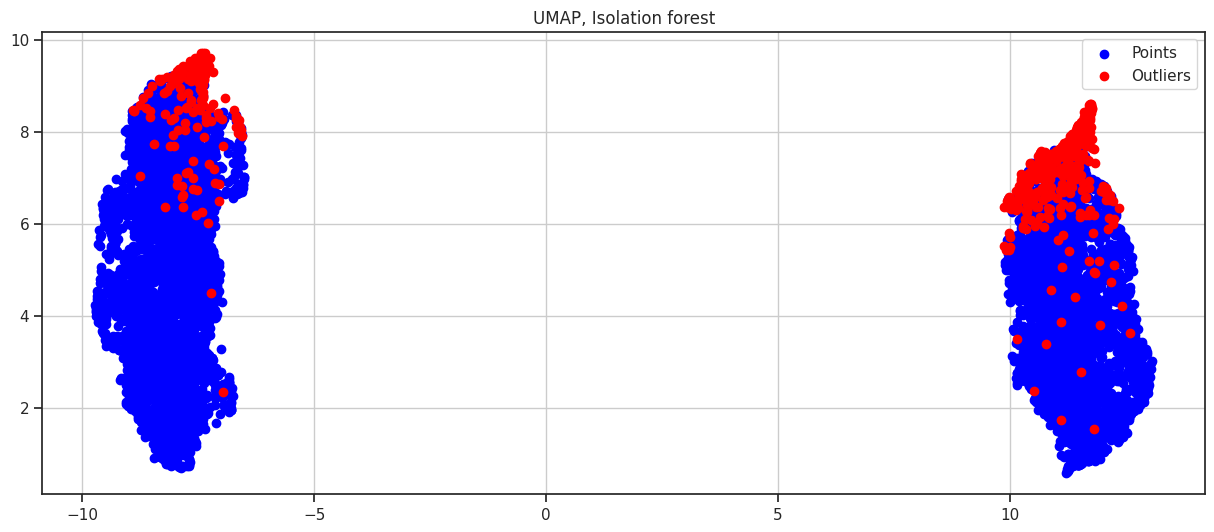

In [64]:
visualize(isolation_forest_preds, embeddings_UMAP, 'UMAP, Isolation forest')

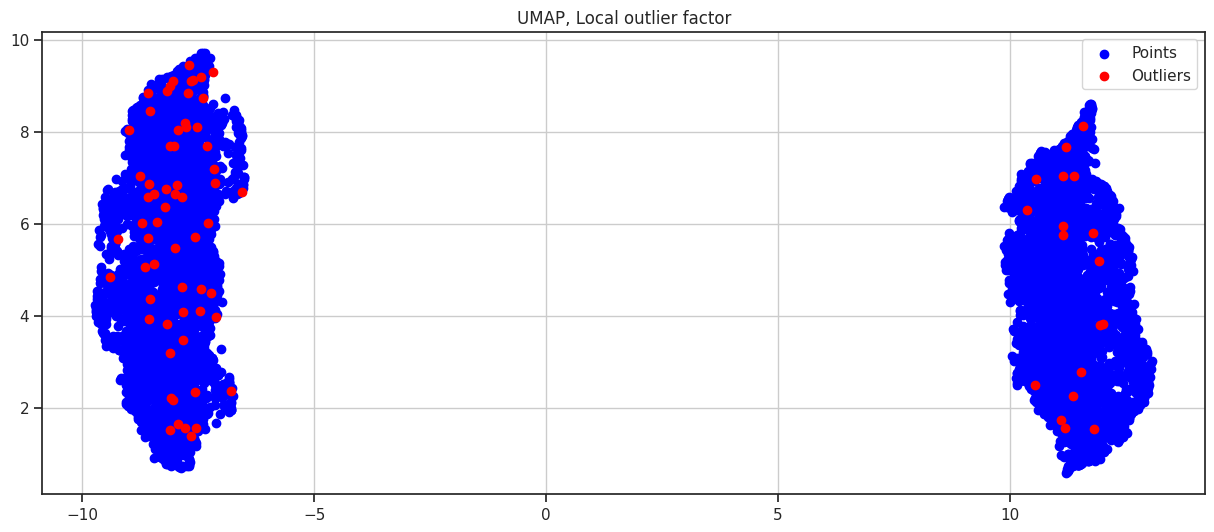

In [65]:
visualize(local_outlier_factor_preds, embeddings_UMAP, 'UMAP, Local outlier factor')

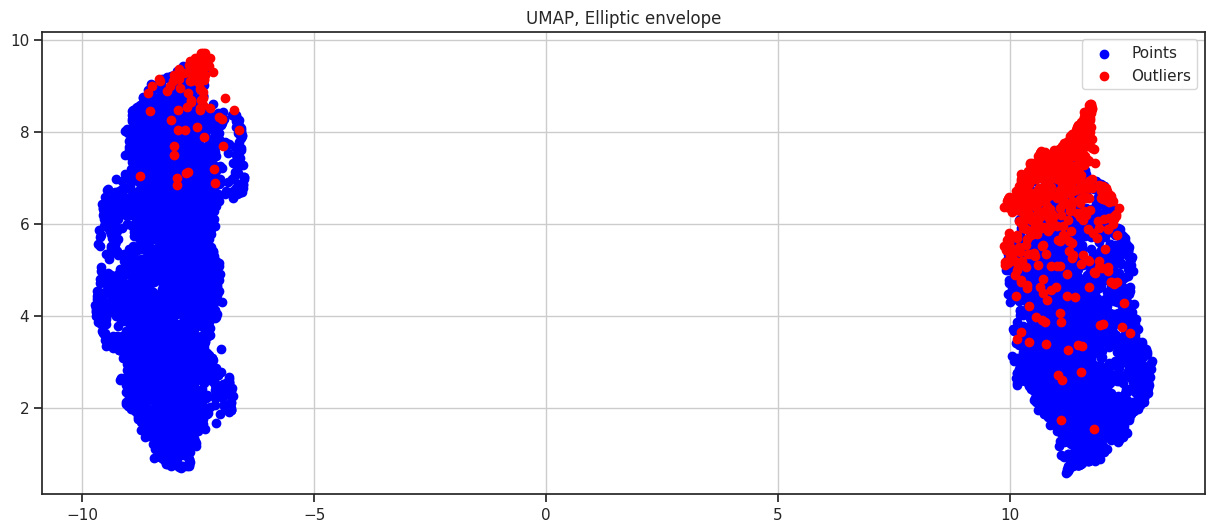

In [66]:
visualize(elliptic_envelope_preds, embeddings_UMAP, 'UMAP, Elliptic envelope')

У UMAP, как и у TSNE получились 2 локальных кластера, но они больше сжаты по горизонтали
- Результат работы аналогичен оному у TSNE
- Тоже самое, что и у TSNE, но на сей раз выбросы преобладают у верхов кластеров
- Результат работы аналогичен оному у TSNE
- Тоже самое, что и у TSNE, но теперь правый кластер "забрал" часть выбросов у левого

### ML System Design

Датасет SST-2 использовался для обучения классификации позитивных и негативных отзывов к фильмам, здесь в ноутбуке приведена модель классификации

В общем-то, довольно очевидно, что данная модель нужна, чтобы пользователи могли оставлять отзывы к просмотренным фильмам:
- Если сайт повящён просто отзывам, то это поможет другим пользователям принять мнение о том, стоит ли смотреть данный фильм или нет
- Если это онлайн-кинотеатр, то помимо предыдущего свойства преимущество состоит в том, что владельцы кинотеатра могут принимать решения, нужно ли в будущем покупать права на показ похожих с этим фильмов или нет

Что касается недостатков, то многие отзывы не являются информативными, так как являются короткими и не поясняют, за что автор поcтавил свою оценку, это усложняет работу классификатору

### Выводы

В данной курсовой работе я поработал с достаточно известным датасетом, использовавшимся во многих paper-ах (не знаю, как нормально это пперевести), поупражнялся в использовании инфраструктуры hugging face, познакомился с алгоритмами поиска выброса и уменьшения размерностей и применил их на практике